In [105]:
# !pip install levenshtein
# !pip install fuzzywuzzy

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process

In [2]:
drinks = pd.read_csv('WHO_data_alc.csv', low_memory=False, header=0)

In [3]:
drinks.columns

Index(['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode',
       'ParentLocation', 'Location type', 'SpatialDimValueCode', 'Location',
       'Period type', 'Period', 'IsLatestYear', 'Dim1 type', 'Dim1',
       'Dim1ValueCode', 'Dim2 type', 'Dim2', 'Dim2ValueCode', 'Dim3 type',
       'Dim3', 'Dim3ValueCode', 'DataSourceDimValueCode', 'DataSource',
       'FactValueNumericPrefix', 'FactValueNumeric', 'FactValueUoM',
       'FactValueNumericLowPrefix', 'FactValueNumericLow',
       'FactValueNumericHighPrefix', 'FactValueNumericHigh', 'Value',
       'FactValueTranslationID', 'FactComments', 'Language', 'DateModified'],
      dtype='object')

Location = Country

Period = year

Dim1 = Alcohol cateogory

FactValueNumeric = Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)

In [74]:
df = drinks[['Location', 'Period', 'Dim1', 'FactValueNumeric', 'FactValueNumericLow','FactValueNumericHigh']]
df

,Location,Period,Dim1,FactValueNumeric,FactValueNumericLow,FactValueNumericHigh
0,Afghanistan,2019,Beer,0.00,0.0,0.0
1,Afghanistan,2019,Other alcoholic beverages,0.00,0.0,0.0
2,Afghanistan,2019,Wine,0.00,0.0,0.0
3,Algeria,2019,Other alcoholic beverages,0.00,0.0,0.0
4,Andorra,2019,Other alcoholic beverages,0.00,0.0,0.0
...,...,...,...,...,...,...
47784,United States of America,1960,Spirits,3.26,NaN,NaN
47785,United States of America,1960,Beer,3.75,NaN,NaN
47786,Austria,1960,Beer,4.70,NaN,NaN
47787,United States of America,1960,All types,7.83,NaN,NaN


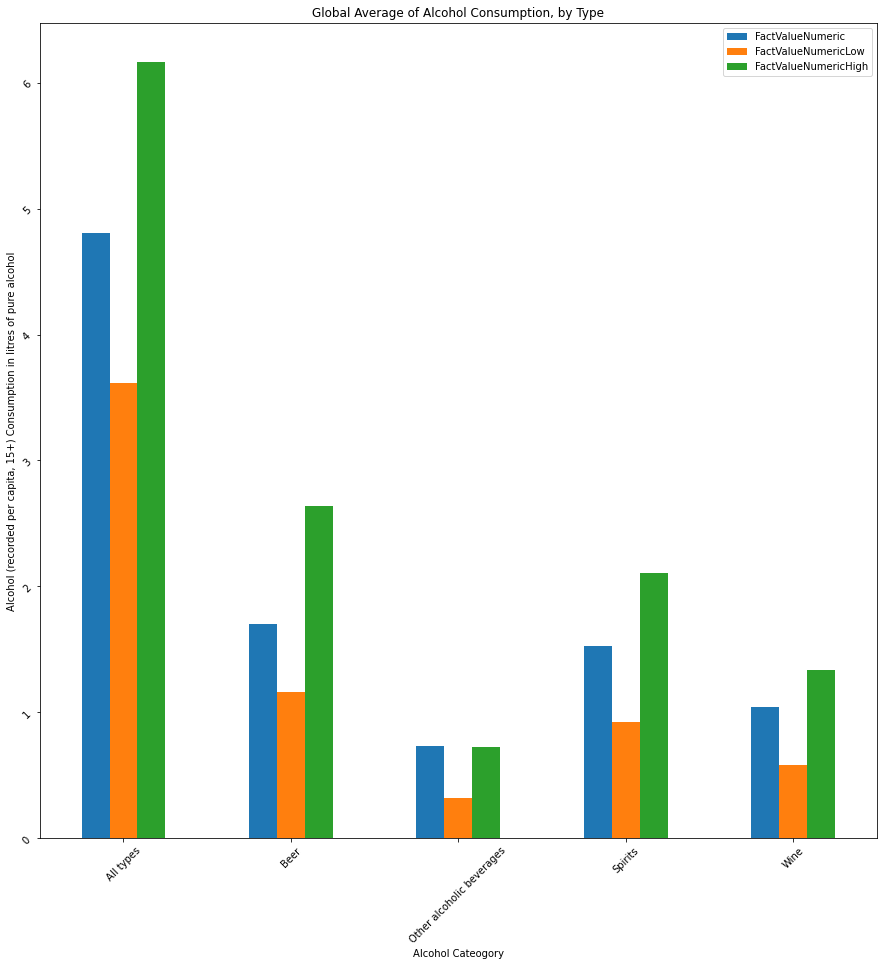

In [167]:
ax = df.drop(['Period'], axis=1).groupby('Dim1').mean().plot(kind='bar', figsize=(15,15), title='Global Average of Alcohol Consumption, by Type', 
                                                        ylabel='Alcohol (recorded per capita, 15+) Consumption in litres of pure alcohol', xlabel='Alcohol Cateogory')

ax.tick_params(rotation=45)

In [5]:
all_types = df[df['Dim1'] == 'All types']
beer = df[df['Dim1'] == 'Beer']
wine = df[df['Dim1'] == 'Wine']
other = df[df['Dim1'] == 'Other alcoholic beverages']

In [8]:
gdp_pc = pd.read_csv('gdp_per_capita.csv')

In [9]:
gdp_pc

,Country Name,Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24712.493263,26441.619936,26893.011506,28396.908423,28452.170615,29350.805019,30253.279358,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,147.612227,147.014904,156.189192,182.243917,162.347592,180.214908,190.845484,192.337167,...,1736.166560,1713.899299,1703.596298,1549.037940,1431.778723,1573.063386,1574.978648,1530.059177,1359.618224,NaN
2,Afghanistan,AFG,59.773234,59.860900,58.458009,78.706429,82.095307,101.108325,137.594298,160.898434,...,638.845852,624.315455,614.223342,556.007221,512.012778,516.679862,485.668419,494.179350,516.747871,NaN
3,Africa Western and Central,AFW,107.932233,113.081647,118.831107,123.442888,131.854402,138.526332,144.326212,128.582470,...,1965.118485,2157.481149,2212.853135,1894.310195,1673.835527,1613.473553,1704.139603,1777.918672,1710.073363,NaN
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5100.097027,5254.881126,5408.411700,4166.979833,3506.073128,4095.810057,3289.643995,2809.626088,1776.166868,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3410.859780,3704.784221,3902.676013,3520.766449,3759.560246,4009.380987,4384.048892,4416.108358,4346.637931,NaN
262,"Yemen, Rep.",YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1446.536472,1607.152173,1674.002572,1601.830063,1152.720966,964.264811,758.145242,NaN,NaN,NaN
263,South Africa,ZAF,443.009920,454.962013,473.011405,511.497364,548.996058,584.704163,621.220543,675.135345,...,8222.197279,7467.079185,6988.808739,6259.839681,5756.965741,6690.939847,7005.095413,6624.761865,5655.867654,NaN
264,Zambia,ZMB,232.188564,220.042067,212.578449,213.896759,242.384473,303.281740,343.373670,360.201239,...,1763.069442,1878.346811,1762.427817,1338.290927,1280.806543,1535.196574,1516.368371,1305.001031,985.132436,NaN


In [124]:
def NameFinder(name):
    countries = gdp_pc['Country Name'].drop_duplicates().to_list() + df['Location'].drop_duplicates().to_list()
    gdp_name, alc_name = process.extract(name, countries, limit=2)
    return print('Country Name in GDP Dataset', gdp_name, 'Country Name in Alc Dataset', alc_name)

In [127]:
NameFinder('Ukraine')

Country Name in GDP Dataset ('Ukraine', 100) Country Name in Alc Dataset ('Ukraine', 100)


In [62]:
def CountryGDP(country):
    country_gdp = gdp_pc[gdp_pc['Country Name'] == country].T.drop(['Country Name', 'Code', 'Unnamed: 65'])
    country_gdp['Year'] = country_gdp.index
    country_gdp.columns = ['GDP', 'Year']
    country_gdp = country_gdp.reset_index()
    country_gdp = country_gdp.drop(['index'], axis=1)
    country_gdp['scaled gdp'] = country_gdp['GDP'] / country_gdp['GDP'].abs().max()
    return country_gdp

In [89]:
def CountryConspumtion(country):
    country_cons = all_types[all_types['Location'] == country][['Period', 'FactValueNumeric']].reset_index().drop(['index'], axis=1)
    country_cons.columns = ['Year', 'alc_cons_litre']
    country_cons = country_cons.sort_values('Year')
    country_cons['alc_cons_litre_scaled'] = country_cons['alc_cons_litre'] / country_cons['alc_cons_litre'].abs().max()
    return country_cons

In [92]:
usa_gdp = CountryGDP('United States')
usa_consumption = CountryConspumtion('United States of America')

In [109]:
gbr_gdp = CountryGDP('United Kingdom')
gbr_consumption = CountryConspumtion('United Kingdom of Great Britain and Northern Ireland')

In [128]:
ukr_gdp = CountryGDP('Ukraine')
ukr_consumption = CountryConspumtion('Ukraine')

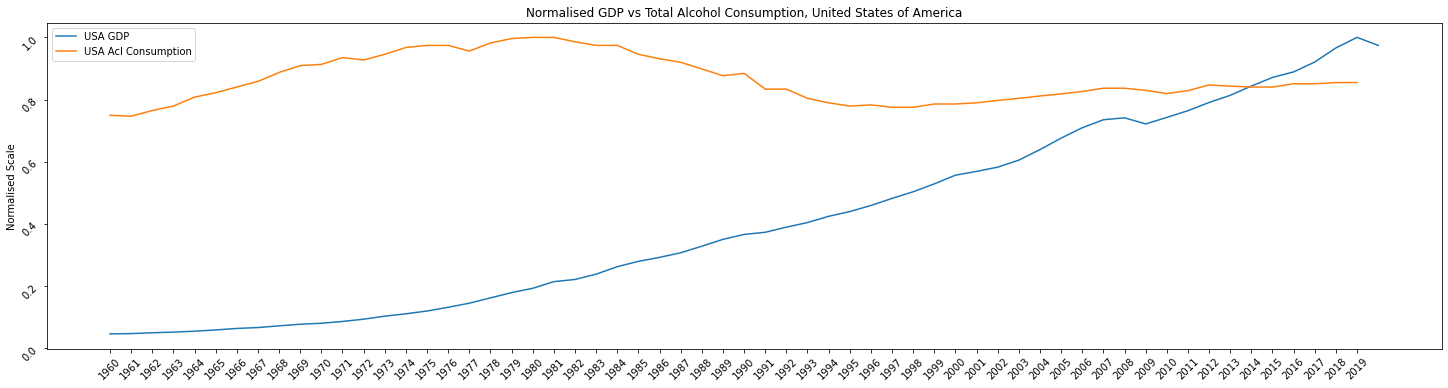

In [170]:
x1 = np.arange(0, len(usa_gdp), step=1)
y1 = usa_gdp['scaled gdp'].to_list()
x2 = np.arange(0, len(usa_consumption), step=1)
y2 = usa_consumption['alc_cons_litre_scaled'].to_list()
years = usa_consumption['Year'].to_list()

fig, ax = plt.subplots(1,1,figsize=(25,6))

ax.plot(x1, y1, label='USA GDP')
ax.plot(x2, y2, label='USA Acl Consumption')

ax.set_xticks(np.arange(len(usa_consumption)))
ax.set_xticklabels(years)
ax.tick_params(labelrotation=45)
ax.set_title('Normalised GDP vs Total Alcohol Consumption, United States of America')
ax.set_ylabel('Normalised Scale')
ax.legend()

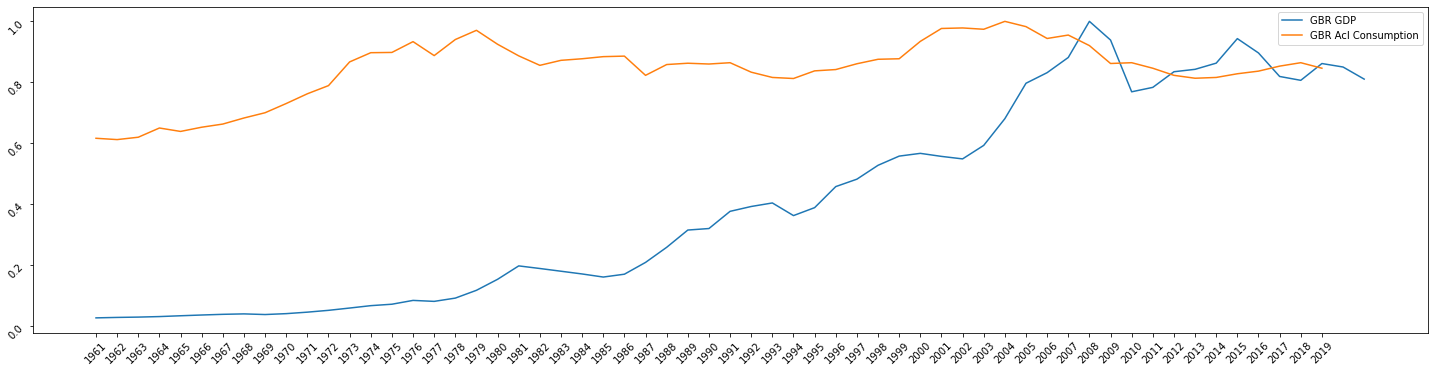

In [119]:
x1 = np.arange(0, len(gbr_gdp), step=1)
y1 = gbr_gdp['scaled gdp'].to_list()
x2 = np.arange(0, len(gbr_consumption), step=1)
y2 = gbr_consumption['alc_cons_litre_scaled'].to_list()
years = gbr_consumption['Year'].to_list()

fig, ax = plt.subplots(1,1,figsize=(25,6))

ax.plot(x1, y1, label='GBR GDP')
ax.plot(x2, y2, label='GBR Acl Consumption')

ax.set_xticks(np.arange(len(gbr_consumption)))
ax.set_xticklabels(years)
ax.tick_params(labelrotation=45)
ax.legend()